In [37]:
%%capture
%load_ext autoreload
%autoreload 2
%matplotlib inline
# %cd .. 
import os, sys
sys.path.append("..")
import statnlpbook.util as util
import statnlpbook.sequence as seq
from statnlpbook.gmb import load_gmb_dataset
import pandas as pd
import matplotlib
import warnings
warnings.filterwarnings('ignore')
matplotlib.rcParams['figure.figsize'] = (8.0, 5.0)
from collections import defaultdict, Counter
from random import random

<!---
Latex Macros
-->
$$
\newcommand{\Xs}{\mathcal{X}}
\newcommand{\Ys}{\mathcal{Y}}
\newcommand{\y}{\mathbf{y}}
\newcommand{\balpha}{\boldsymbol{\alpha}}
\newcommand{\bbeta}{\boldsymbol{\beta}}
\newcommand{\aligns}{\mathbf{a}}
\newcommand{\align}{a}
\newcommand{\source}{\mathbf{s}}
\newcommand{\target}{\mathbf{t}}
\newcommand{\ssource}{s}
\newcommand{\starget}{t}
\newcommand{\repr}{\mathbf{f}}
\newcommand{\repry}{\mathbf{g}}
\newcommand{\x}{\mathbf{x}}
\newcommand{\prob}{p}
\newcommand{\bar}{\,|\,}
\newcommand{\vocab}{V}
\newcommand{\params}{\boldsymbol{\theta}}
\newcommand{\param}{\theta}
\DeclareMathOperator{\perplexity}{PP}
\DeclareMathOperator{\argmax}{argmax}
\DeclareMathOperator{\argmin}{argmin}
\newcommand{\train}{\mathcal{D}}
\newcommand{\counts}[2]{\#_{#1}(#2) }
\newcommand{\length}[1]{\text{length}(#1) }
\newcommand{\indi}{\mathbb{I}}
$$

In [2]:
%%HTML
<style>
.rendered_html td {
    font-size: x-large;
    text-align: left; !important
}
.rendered_html th {
    font-size: x-large;
    text-align: left; !important
}
</style>

In [3]:
%load_ext tikzmagic

# Natural Language Processing (NLP) Lecture 4:
# Sequence Labeling

&nbsp;

### Marcel Bollmann (marcel@di.ku.dk)

## Sequence Labeling

+ Assigning exactly one label to each element in a sequence

+ In context of RNNs, example of **one-to-one** paradigm

<center><img src="../img/one_to_one.png"></center>

## Part-of-speech tagging

Assign each token in a sentence its **part-of-speech (POS) tag**.

| 1 | 2 | 3 | 4 | 5 | 6 | 7 |
|-|-|-|-|-|-|-|
| I | predict | that | it | will | rain | tonight |
| PRP | VBP | IN | PRP | MD | VB | NN |

## Part-of-speech tagsets

+ POS tags group words with **similar grammatical properties**
+ Granularity of tags can differ
+ *For example:* English Penn TreeBank Tagset distinguishes four types of nouns

| | | |
|-|-|-|
| **NN** | noun, singular or mass | *cat, rain* |
| **NNS** | noun, plural | *cats, tables* |
| **NNP** | proper noun, singular | *John, IBM* |
| **NNPS** | proper noun, plural | *Muslims, Philippines* |


### Crucial challenge: Ambiguity!

| | | | | | |
|-|-|-|-|-|-|
| He | is | treated | for | **back** | injury |
| PRP | VBP | VBN | IN | **NN** | NN |

| | | | | | |
|-|-|-|-|-|-|
| He | is | sent | **back** | to | prison |
| PRP | VBP | VBN | **RB** | TO | NN |

| | | | | |
|-|-|-|-|-|
| I | can | **back** | this | up | 
| PRP | MD | **VB** | DT | RP |



## GMB dataset

+ GMB = Groningen Meaning Bank
+ https://www.kaggle.com/shoumikgoswami/annotated-gmb-corpus/


In [4]:
tokens, pos, ents = load_gmb_dataset('../data/gmb/GMB_dataset_utf8.txt')

pd.DataFrame([tokens[2], pos[2]])

,0,1,2,3,4,5,6,7,8,9,10,11,12,13
0,They,marched,from,the,Houses,of,Parliament,to,a,rally,in,Hyde,Park,.
1,PRP,VBD,IN,DT,NNS,IN,NN,TO,DT,NN,IN,NNP,NNP,.


In [5]:
examples = {}
counts = Counter(tag for sent in pos for tag in sent)
words = defaultdict(set)
for x_s, y_s in zip(tokens, pos):
    for i, (x, y) in enumerate(zip(x_s, y_s)):
        if y not in examples or random() > 0.97:
            examples[y] = [x_s[j] + "/" + y_s[j] if i == j else x_s[j] for j in range(max(i-1,0),min(i+2,len(x_s)))]
        words[y].add(x)
sorted_tags = sorted(counts.items(),key=lambda x:-x[1])
sorted_tags_with_examples = [(t,c,len(words[t])," ".join(examples[t])) for t,c in sorted_tags]

sorted_tags_table = pd.DataFrame(sorted_tags_with_examples, columns=['Tag','Count','Unique Tokens','Example'])

In [6]:
sorted_tags_table[:10]

,Tag,Count,Unique Tokens,Example
0,NN,9307,2087,the capital/NN .
1,NNP,8189,2069,dictator Saddam/NNP Hussein
2,IN,7759,94,back in/IN custody
3,DT,6310,40,of the/DT stalemate
4,JJ,4875,1214,the war-shattered/JJ nation
5,NNS,4803,1102,after gunmen/NNS fired
6,.,2992,3,territory ./.
7,VBD,2429,470,which produced/VBD the
8,VBN,2060,588,be held/VBN May
9,",",1953,1,"arthritis ,/, but"


## Sequence Labeling as Structured Prediction

* Input Space $\Xs$: sequences of items to label
* Output Space $\Ys$: sequences of output labels
* Model: $s_{\params}(\x,\y)$
* Prediction: $\argmax_\y s_{\params}(\x,\y)$

## Conditional Models
Model probability distributions over label sequences $\y$ conditioned on input sequences $\x$

$$
s_{\params}(\x,\y) = \prob_\params(\y|\x)
$$ 

* Analogous to conditional models of [text classification](doc_classify_slides_short.ipynb) chapter

## Local Models / Classifiers
A **fully factorised** or **local** model:

$$
p_\params(\y|\x) = \prod_{i=1}^n p_\params(y_i|\x,i)
$$

* Labels are independent of each other
* Inference in this model is trivial

### Example

$$
\prob_\params(\text{"PRP MD VB"} \bar \text{"it will rain"}) = \\\\ \prob_\params(\text{"PRP"}\bar \text{"it will rain"},1) \cdot \prob_\params(\text{"MD"} \bar \text{"it will rain"},2) \cdot \prob_\params(\text{"VB"} \bar \text{"it will rain"},3)
$$

### Parametrisation

**Log-linear classifier** $p_\params(y\bar\x,i)$ to predict class for sentence $\x$ and position $i$

$$
  p_\params(y\bar\x,i) = \frac{1}{Z_\x} \exp \langle \repr(\x,i),\params_y \rangle
$$


+ $\repr(\x,i)$ is a **feature function**
+ How far can we get with very simple features?

Bias:
$$
\repr_0(\x,i) = 1
$$

Word at token to tag:
$$
\repr_w(\x,i) = \begin{cases}1 \text{ if }x_i=w \\\\ 0 \text{ else} \end{cases}
$$

In [57]:
def feat_1(x,i):
    return {
        'bias': 1.0,  
        'word:' + x[i]: 1.0,
    }

train = list(zip(tokens[:-200], pos[:-200]))
dev = list(zip(tokens[-200:], pos[-200:]))

local_1 = seq.LocalSequenceLabeler(feat_1, train, class_weight='balanced')

We can assess the accuracy of this model on the development set.

In [58]:
seq.accuracy(dev, local_1.predict(dev))

0.8797186400937866

### How to Improve?

Look at **confusion matrix**

In [29]:
import matplotlib.pyplot as plt
plt.rcParams['figure.figsize'] = [7, 7]
import matplotlib.pylab as plb
plb.rcParams['figure.dpi'] = 120

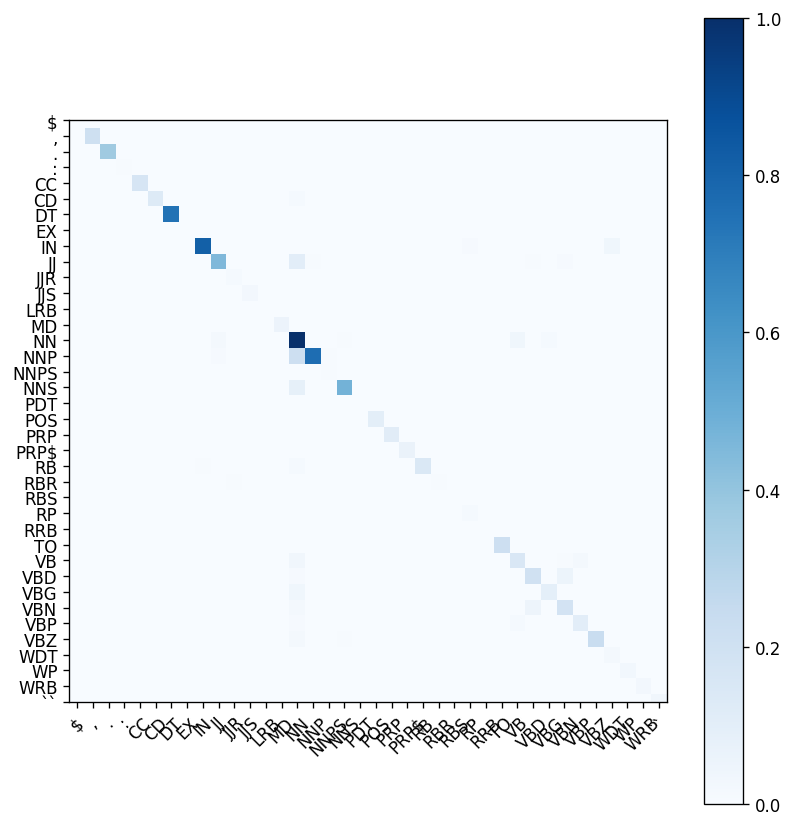

In [30]:
seq.plot_confusion_matrix(dev, local_1.predict(dev), normalise=True)

Shows:

* mostly strong diagonal (good predictions)
* `NN` receives a lot of wrong counts, often confused with `NNP`

In [31]:
util.Carousel(local_1.errors(dev, 
                             filter_guess=lambda y: y=='NN',
                             filter_gold=lambda y: y=='NNP'))

* "Mayor", "Toussaint" or "H.I.V." are misclassified as common nouns 
* For $f_{\text{word},w}$ feature template weights are $0$ 

Suggests that word has not appeared in the training set! 

Proper nouns tend to be capitalised!

In [33]:
def feat_2(x,i):
    return {
        'bias': 1.0,  
        'word:' + x[i].lower(): 1.0,
        'first_upper:' + str(x[i][0].isupper()): 1.0,
    }
local_2 = seq.LocalSequenceLabeler(feat_2, train)
seq.accuracy(dev, local_2.predict(dev))

0.9144196951934349

To confirm that these results actually from improved `NN`/`NNP` prediction, let us look at the confusion matrix again:

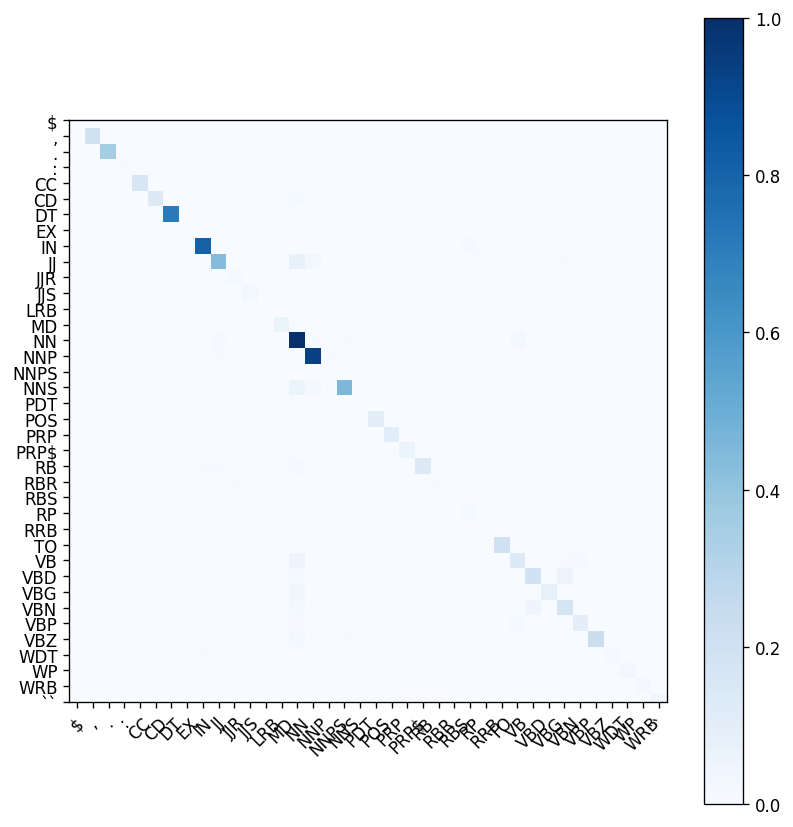

In [34]:
seq.plot_confusion_matrix(dev, local_2.predict(dev), normalise=True)

Solved! 

## Named entity recognition (NER)

| |
|-|
| \[Barack Obama\]<sub>PER</sub> was born in \[Hawaii\]<sub>LOC</sub> |


## NER as sequence labeling

Label tokens as beginning (B), inside (I), or outside (O) a **named entity:**

| | | | | | |
|-|-|-|-|-|-|
| Barack | Obama | was |  born | in | Hawaii |
| B-PER | I-PER | O |  O | O | B-LOC |


+ Many tasks can be framed as sequence labeling using this idea!

GMB dataset also has named entity annotation:

In [13]:
pd.DataFrame([tokens[12][:11], pos[12][:11], ents[12][:11]])

,0,1,2,3,4,5,6,7,8,9,10
0,Iran,'s,new,President,Mahmoud,Ahmadinejad,said,Tuesday,that,European,incentives
1,NNP,POS,JJ,NNP,NNP,NNP,VBD,NNP,IN,JJ,NNS
2,B-gpe,O,O,B-per,I-per,I-per,O,B-tim,O,B-gpe,O


In [54]:
examples = {}
counts_ent = Counter(tag[2:] for sent in ents for tag in sent if tag.startswith("B-"))
in_entity = False
for x_s, y_s in zip(tokens, ents):
    for i, (x, y) in enumerate(zip(x_s, y_s)):
        if y == "O":
            in_entity = False
            continue
        y_ent = y[2:]
        if y[0] == "B":
            if y_ent not in examples or random() > 0.6:
                examples[y_ent] = [x]
                in_entity = True
            else:
                in_entity = False
        if y[0] == "I" and in_entity:
            examples[y_ent].append(x)

sorted_ents = sorted(counts_ent.items(),key=lambda x:-x[1])
sorted_ents_with_examples = [(t,c," ".join(examples[t])) for t,c in sorted_ents]

sorted_ents_table = pd.DataFrame(sorted_ents_with_examples, columns=['Entity Type','Count','Example'])

In [55]:
sorted_ents_table

,Entity Type,Count,Example
0,geo,2070,Dujail
1,org,1237,Security Council
2,gpe,1230,Haitian
3,tim,1160,1982
4,per,1107,Mr. Annan
5,art,53,Christopher Hotel
6,eve,45,Summer Olympics
7,nat,20,XDR-TB


Can we run our simple **local model** on this?

In [60]:
train_ner = list(zip(tokens[:-200], ents[:-200]))
dev_ner = list(zip(tokens[-200:], ents[-200:]))

def feat_2(x,i):
    return {
        'bias': 1.0,  
        'word:' + x[i].lower(): 1.0,
        'first_upper:' + str(x[i][0].isupper()): 1.0,
    }
local_2 = seq.LocalSequenceLabeler(feat_2, train_ner)
seq.accuracy(dev_ner, local_2.predict(dev_ner))

0.9329425556858147

This seems great, but tag distribution is also **highly skewed**:

In [61]:
only_o = [tuple(['O'] * len(tags)) for _, tags in dev_ner]
seq.accuracy(dev_ner, only_o)

0.8527549824150059

In [63]:
def get_spans(labels):
    spans = []
    current = [None, None, None]
    for i, label in enumerate(labels):
        if label.startswith("I-") and label[2:] == current[0]:
            # continued span
            continue
        # push span, if there is any
        if current[0] is not None:
            current[2] = i
            spans.append(current)
            current = [None, None, None]
        if label.startswith("B-"):
            current[0] = label[2:]
            current[1] = i
    if current[0] is not None:
        current[2] = len(labels)
        spans.append(current)
    return spans

def _calculate_prf(preds, golds):
    total_pred, total_gold, match = 0, 0, 0
    for pred, gold in zip(preds, golds):
        pred_s = get_spans(pred)
        gold_s = get_spans(gold)
        total_pred += len(pred_s)
        total_gold += len(gold_s)
        match += sum(s in pred_s for s in gold_s)
    # precision: % of entities found by the system that are correct
    p = match / total_pred
    # recall: % of entities in dataset found by the system
    r = match / total_gold
    # f-score: harmonic mean of precision and recall
    f = 2 * (p * r) / (p + r)

    return p, r, f

def calculate_prf(goldset, preds):
    return _calculate_prf(preds, [s[1] for s in goldset])

Tasks like NER are more commonly evaluated with...

### Precision, recall, and F-measure

\begin{align}
\text{precision} & = \frac{|\text{predicted}\cap\text{annotated}|}{|\text{predicted}|} \\[.5em]
\text{recall} & = \frac{|\text{predicted}\cap\text{annotated}|}{|\text{annotated}|} \\[.5em]
F & = 2 \cdot \frac{\text{precision}\cdot\text{recall}}{\text{precision}+\text{recall}} \\
\end{align}


In [64]:
calculate_prf(dev_ner, local_2.predict(dev_ner))

(0.7130681818181818, 0.5770114942528736, 0.6378653113087674)

## Sequence labeling with neural networks

Typically: Bi-directional RNNs, e.g. LSTMs


<center>
  <img src='../img/bplank_bilstm.png'/>
</center>

A recurrent neural network (plain RNN, LSTM, GRU, ...) computes its output based on a hidden, internal state:

$$
 {\mathbf{y}}_{t} = \text{RNN}(\x_t, {\mathbf{h}}_{t})
$$



A **bi-directional** RNN is just two uni-directional RNNs combined:

\begin{align}
 \overrightarrow{\mathbf{y}_{t}} & = \overrightarrow{\text{RNN}}(\x_t, \overrightarrow{\mathbf{h}_{t}})\\
 \overleftarrow{\mathbf{y}_{t}} & = \overleftarrow{\text{RNN}}(\x_t, \overleftarrow{\mathbf{h}_{t}}) 
 \\
 {\mathbf{y}}_{t} & = \overrightarrow{\mathbf{y}_{t}} \oplus \overleftarrow{\mathbf{y}_{t}} \\
\end{align}

where

+ $\overrightarrow{\text{RNN}}$ reads the input sequence $\x$ from left to right
+ $\overleftarrow{\text{RNN}}$ reads the input sequence $\x$ from right to left


A different illustration of the same concept:

<center>
  <img style="width:28vw;" src='../img/genthial_bilstm.png'/>
</center>

<span class="font-size:small;">Source: https://guillaumegenthial.github.io/sequence-tagging-with-tensorflow.html</span>

To predict label probabilities, we use the **softmax function**:


$$
\begin{aligned}
 {\mathbf{y}}_{t} & = \overrightarrow{\mathbf{y}_{t}} \oplus \overleftarrow{\mathbf{y}_{t}} \\
 \hat{\mathbf{y}}_{t} & = \text{softmax}(\mathbf{W}^o \mathbf{y}_{t}) \in \mathbb{R}^{|V|} \\
\end{aligned}
$$


### An important technical detail

The linear transformation $\mathbf{W}^o \mathbf{y}_{t}$ is usually not modelled as part of the RNN itself in most deep learning frameworks.

Instead, look for one of

+ **feed-forward layer**
+ **dense layer** (*e.g. in Keras*)
+ **linear layer** (*e.g. in PyTorch*)

with a softmax activation

Remember the log-linear classifier:

$$
  p_\params(y\bar\x,i) = \frac{1}{Z_\x} \exp \langle \repr(\x,i),\params_y \rangle
$$

A bi-LSTM model with a softmax layer on top is also modelling $p_\params(y\bar\x,i)$, so if you take $\params$ to be the set of parameters of the neural network, then:

\begin{align}
 \hat{\mathbf{y}}_{t} & = \text{softmax}(\hat{\mathbf{h}}_{t}) \\
  &= \frac{1}{Z_\x} \exp \langle \hat{\mathbf{h}}_{t},\params_y \rangle \\
\end{align}

**What, then, are the most important differences to the simple log-linear approach?**

What haven't we modeled yet?

## There are *dependencies* between consecutive labels!

Can you think about fitting words for this POS tag sequence?

| | | |
|-|-|-|
| DT | JJ | NN |
| *determiner* | *adjective* | *noun (singular or mass)* |

What about this one?

| | |
|-|-|
| DT | VB |
| *determiner* | *verb (base form)* |

+ After determiners (`DT`), adjectives and nouns are much more likely than verbs
+ *Local* models cannot *directly* capture this

In [65]:
util.Carousel(local_2.errors(dev_ner, 
                             filter_guess=lambda y: y.startswith("I-"),
                             filter_gold=lambda y: y.startswith("B-")))

In the IOB tagging scheme:

+ `I-[label]` can logically **only** appear after `B-[label]`!

The following can **never** be valid tag sequences:

* `O  I-per`

* `B-per  I-geo`


What if we went from this...

$$
p_\params(\y|\x) = \prod_{i=1}^n p_\params(y_i|\x,i)
$$

...to this?

$$
p_\params(\y|\x) = \prod_{i=1}^n p_\params(y_i|\x,y_{i-1},i)
$$


### First-order Markov assumption

* Probability of a label depends only on the previous label


### Example

$$
\begin{aligned}
\prob_\params(\text{"O I-per I-per"} \bar \text{"president Bill Clinton"}) = ~ & \prob_\params(\text{"O"}\bar \text{"president Bill Clinton"},\text{"<PAD>"},1) ~ \cdot \\
& \prob_\params(\text{"I-per"} \bar \text{"president Bill Clinton"},\text{"O"},2) ~ \cdot \\
& \prob_\params(\text{"I-per"} \bar \text{"president Bill Clinton"},\text{"I-per"},3) \\
\end{aligned}
$$

## Maximum Entropy Markov Models (MEMM)

Log-linear version with access to previous label: 

$$
  p_\params(y_i|\x,y_{i-1},i) = \frac{1}{Z_{\x,y_{i-1},i}} \exp \langle \repr(\x,y_{i-1},i),\params_{y_i} \rangle
$$

where $Z_{\x,y_{i-1},i}=\sum_y \exp \langle \repr(\x,y_{i-1},i),\params_{y_i} \rangle $ is a *local* per-token normalisation factor

### Training MEMMs
Optimising the conditional likelihood 

$$
\sum_{(\x,\y) \in \train} \log \prob_\params(\y|\x)
$$

Decomposes nicely: 
$$
\sum_{(\x,\y) \in \train} \sum_{i=1}^{|\x|} \log \prob_\params(y_i|\x,y_{i-1},i)   
$$

Easy to train
* Equivalent to a **logistic regression objective** for a classifier that assigns labels based on previous gold labels

However...

### Local normalization introduces *label bias*

+ Tag probabilities always sum to 1 at each position
+ Can lead to MEMMs effectively "ignoring" the inputs

## Conditional Random Fields (CRF)

Replace *local* with *global* normalization:

$$
  p_\params(y_i|\x,y_{i-1},i) = \frac{1}{Z_{\x}} \exp \langle \repr(\x,y_{i-1},i),\params_{y_i} \rangle
$$

where $Z_{\x}=\sum_\y   \prod_i^{|\x|} \exp \langle \repr(\x,y_{i-1},i), \params_{y_i} \rangle$ is the *partition function*

***

+ More precisely, this is a **linear-chain CRF**.

  (CRFs can be applied to any graph structure, but we are only considering sequences.)


## &#128077;

+ Finds globally optimal set of features
+ Eliminates label bias

## &#128078;

+ More difficult to train (—cannot break down into local terms anymore!)

The best of both worlds?

## BiLSTM-CRF

+ We can **combine** our bi-directional LSTM model with a CRF!

<center>
  <img src="../img/ner_bilstm.png">
</center>

<center>
  <img src="../img/ner_bilstm_crf.png">
</center>

## Prediction in MEMMs, CRFs, BiLSTM-CRFs, ...

To predict the best label sequence, find a $\y^*$ with maximal conditional probability

$$
\y^* =\argmax_\y \prob_\params(\y|\x).
$$

### Problem

We cannot simply choose each label in isolation because **decisions depend on each other.**

## Greedy prediction

Simplest option:
* Choose highest scoring label for token 1
* Choose highest scoring label for token 2, conditioned on best label from 1
* etc.

Greedy decoding may lead to
## Search Errors

when returned $\y^*$ is not highest scoring **global** solution

## Beam Search

Keep a "beam" of the best $n$ previous solutions

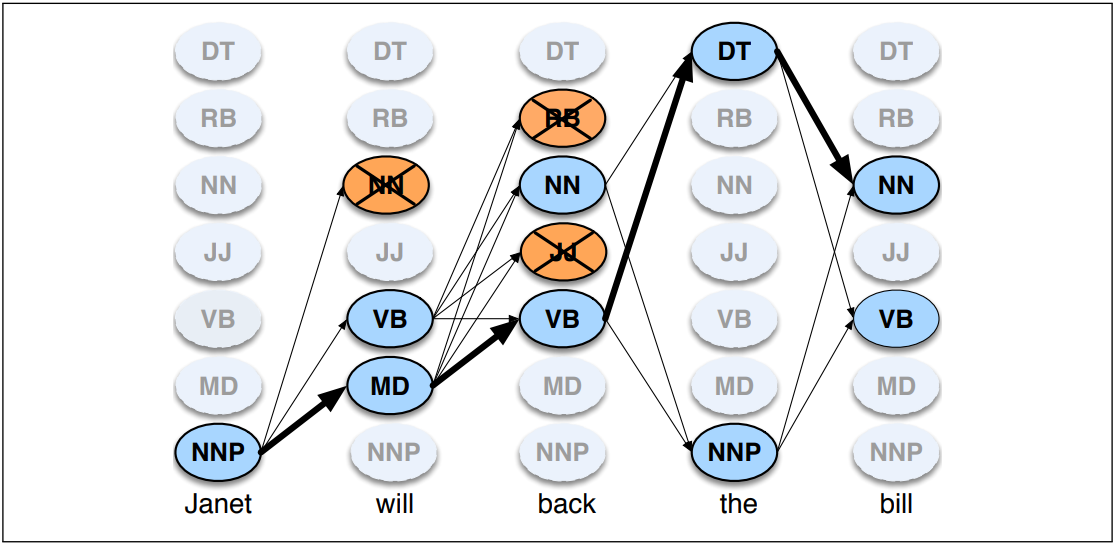
(taken from Jurafsky & Martin, [Speech and Language Processing](https://web.stanford.edu/~jurafsky/slp3/ed3book.pdf), Figure 8.11)

Conditioning on the full history is wasteful for first-order models, instead use 

## Viterbi Algorithm

### Viterbi Algorithm

Dynamic algorithm using a **trellis** with **backpointers**

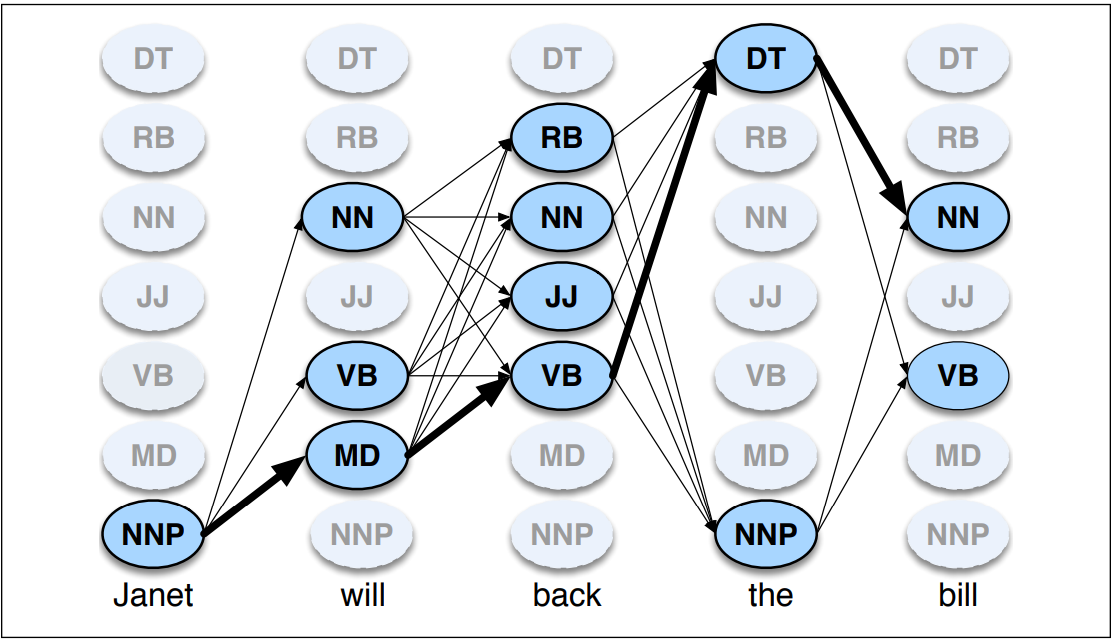
(taken from Jurafsky & Martin, [Speech and Language Processing](https://web.stanford.edu/~jurafsky/slp3/ed3book.pdf), Figure 8.6)

## Summary
* Many problems can be cast as sequence labeling
* Solution 1: Sequence of linear regression classifiers
    * Rely on good feature engineering
* Solution 2: Recurrent neural networks (e.g., bidirectional LSTMs)
    * Rely on substantial amounts of training data
* Solution 3: CRFs to model label dependencies
    * Can be stacked on top of neural networks
    * Require non-trivial search algorithms
    * ...but greedy and beam search often work well


## Background Material 
* Jurafsky & Martin, Speech and Language Processing, [§8.4 and §8.5](https://web.stanford.edu/~jurafsky/slp3/8.pdf) introduces Markov chains, HMMs, & MEMMs
* Tutorial on CRFs: Sutton & McCallum, [An Introduction to Conditional Random Fields for Relational Learning](https://people.cs.umass.edu/~mccallum/papers/crf-tutorial.pdf)
* LSTM-CRF architecture: Huang et al., [Bidirectional LSTM-CRF for Sequence Tagging](https://arxiv.org/pdf/1508.01991v1.pdf)


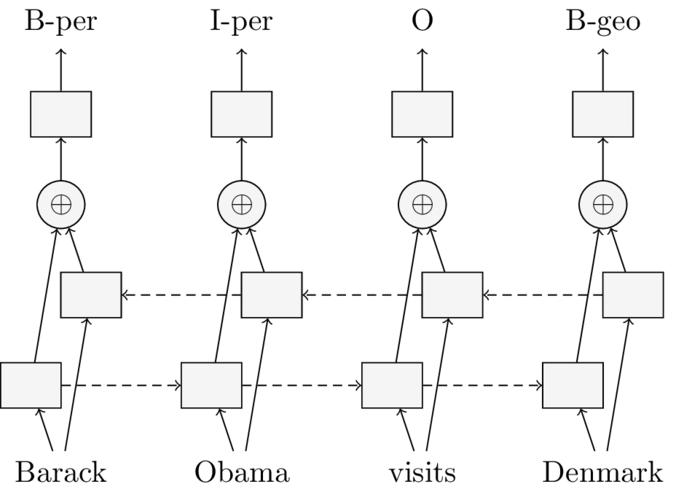

In [21]:
%%tikz -l arrows,positioning -s 1100,500 -sc 0.7

  \tikzset{state/.style={draw,rectangle,minimum height=1.5em,minimum width=2em,
                         inner xsep=1em,inner ysep=0.5em,fill=gray!10},
           addstate/.style={draw,circle,inner sep=0.2em,fill=gray!10},
           emptystate/.style={inner sep=0.4em,text height=0.6em,text depth=0.2em},
           outer/.style={outer sep=0},
           label/.style={align=center,font=\bfseries\itshape\small,text height=0.5em}}

     \node[emptystate]    (I1)    at  (0, 0.0)  {Barack};
     \node[emptystate]    (I2)    at  (3, 0.0)  {Obama};
     \node[emptystate]    (I3)    at  (6, 0.0)  {visits};
     \node[emptystate]    (I4)    at  (9, 0.0)  {Denmark};

     \node[state]         (FRNN1)  at  (-0.5, 1.5)  {};
     \node[state]         (FRNN2)  at  ( 2.5, 1.5)  {};
     \node[state]         (FRNN3)  at  ( 5.5, 1.5)  {};
     \node[state]         (FRNN4)  at  ( 8.5, 1.5)  {};

     \node[state]         (BRNN1)  at  (0.5, 3.0)  {};
     \node[state]         (BRNN2)  at  (3.5, 3.0)  {};
     \node[state]         (BRNN3)  at  (6.5, 3.0)  {};
     \node[state]         (BRNN4)  at  (9.5, 3.0)  {};

     \node[addstate]      (A1)    at  (0, 4.5)  {$\oplus$};
     \node[addstate]      (A2)    at  (3, 4.5)  {$\oplus$};
     \node[addstate]      (A3)    at  (6, 4.5)  {$\oplus$};
     \node[addstate]      (A4)    at  (9, 4.5)  {$\oplus$};

     \node[state]    (CRF1)    at  (0, 6.0)  {};
     \node[state]    (CRF2)    at  (3, 6.0)  {};
     \node[state]    (CRF3)    at  (6, 6.0)  {};
     \node[state]    (CRF4)    at  (9, 6.0)  {};
    
     \node[emptystate]    (O1)    at  (0, 7.5)  {B-per};
     \node[emptystate]    (O2)    at  (3, 7.5)  {I-per};
     \node[emptystate]    (O3)    at  (6, 7.5)  {O};
     \node[emptystate]    (O4)    at  (9, 7.5)  {B-geo};

     \foreach \step in {1,...,4} {
       \draw[->]          (I\step) to (FRNN\step);
       \draw[->]          (I\step) to (BRNN\step);
       \draw[->]          (FRNN\step) to (A\step);
       \draw[->]          (BRNN\step) to (A\step);
       \draw[->]          (A\step) to (CRF\step);
       \draw[->]          (CRF\step) to (O\step);
     }

     \draw[->, densely dashed]  (FRNN1) to (FRNN2);
     \draw[->, densely dashed]  (FRNN2) to (FRNN3);
     \draw[->, densely dashed]  (FRNN3) to (FRNN4);
     \draw[->, densely dashed]  (BRNN4) to (BRNN3);
     \draw[->, densely dashed]  (BRNN3) to (BRNN2);
     \draw[->, densely dashed]  (BRNN2) to (BRNN1);


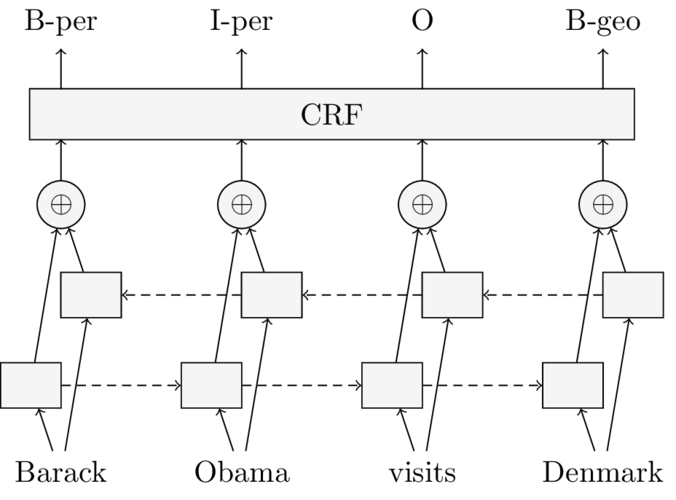

In [22]:
%%tikz -l arrows,positioning -s 1100,500 -sc 0.7

  \tikzset{state/.style={draw,rectangle,minimum height=1.5em,minimum width=2em,
                         inner xsep=1em,inner ysep=0.5em,fill=gray!10},
           crfstate/.style={draw,rectangle,minimum height=1.5em,minimum width=20em,
                         inner xsep=1em,inner ysep=0.5em,fill=gray!10},
           addstate/.style={draw,circle,inner sep=0.2em,fill=gray!10},
           emptystate/.style={inner sep=0.4em,text height=0.6em,text depth=0.2em},
           outer/.style={outer sep=0},
           label/.style={align=center,font=\bfseries\itshape\small,text height=0.5em}}

     \node[emptystate]    (I1)    at  (0, 0.0)  {Barack};
     \node[emptystate]    (I2)    at  (3, 0.0)  {Obama};
     \node[emptystate]    (I3)    at  (6, 0.0)  {visits};
     \node[emptystate]    (I4)    at  (9, 0.0)  {Denmark};

     \node[state]         (FRNN1)  at  (-0.5, 1.5)  {};
     \node[state]         (FRNN2)  at  ( 2.5, 1.5)  {};
     \node[state]         (FRNN3)  at  ( 5.5, 1.5)  {};
     \node[state]         (FRNN4)  at  ( 8.5, 1.5)  {};

     \node[state]         (BRNN1)  at  (0.5, 3.0)  {};
     \node[state]         (BRNN2)  at  (3.5, 3.0)  {};
     \node[state]         (BRNN3)  at  (6.5, 3.0)  {};
     \node[state]         (BRNN4)  at  (9.5, 3.0)  {};

     \node[addstate]      (A1)    at  (0, 4.5)  {$\oplus$};
     \node[addstate]      (A2)    at  (3, 4.5)  {$\oplus$};
     \node[addstate]      (A3)    at  (6, 4.5)  {$\oplus$};
     \node[addstate]      (A4)    at  (9, 4.5)  {$\oplus$};

     \node[crfstate]      (CRF)   at  (4.5, 6.0) {CRF};
     \node[emptystate]    (CRF1)    at  (0, 6.0)  {};
     \node[emptystate]    (CRF2)    at  (3, 6.0)  {};
     \node[emptystate]    (CRF3)    at  (6, 6.0)  {};
     \node[emptystate]    (CRF4)    at  (9, 6.0)  {};
    
     \node[emptystate]    (O1)    at  (0, 7.5)  {B-per};
     \node[emptystate]    (O2)    at  (3, 7.5)  {I-per};
     \node[emptystate]    (O3)    at  (6, 7.5)  {O};
     \node[emptystate]    (O4)    at  (9, 7.5)  {B-geo};

     \foreach \step in {1,...,4} {
       \draw[->]          (I\step) to (FRNN\step);
       \draw[->]          (I\step) to (BRNN\step);
       \draw[->]          (FRNN\step) to (A\step);
       \draw[->]          (BRNN\step) to (A\step);
       \draw[->]          (A\step) to (CRF\step);
       \draw[->]          (CRF\step) to (O\step);
     }

     \draw[->, densely dashed]  (FRNN1) to (FRNN2);
     \draw[->, densely dashed]  (FRNN2) to (FRNN3);
     \draw[->, densely dashed]  (FRNN3) to (FRNN4);
     \draw[->, densely dashed]  (BRNN4) to (BRNN3);
     \draw[->, densely dashed]  (BRNN3) to (BRNN2);
     \draw[->, densely dashed]  (BRNN2) to (BRNN1);
